In [64]:
import inspect
import json
import os
import time

import numpy as np
from functools import wraps
import pandas as pd
import seaborn as sns
import random
import tempfile
import shutil

import pathlib
import zstandard as zstd
import abc
import brotli
import zlib

Platform class

In [94]:


class Platform:
    def __init__(self, algorithm, processing, table_path):
        self.algorithm = algorithm
        self.processing = processing
        self.table_path = table_path
        self.logs = False

        self.benchmark = {"name": type(self.algorithm).__name__, "table_path": table_path}

    def start(self, run_type="test", logs=False):
        self.logs = logs

        if self.logs:
            if isinstance(self.algorithm, LosslessCompressionAlgorithm):
                self.benchmark["isLossLess"] = True
            else:
                self.benchmark["isLossLess"] = False

            if isinstance(self.algorithm, LearningCompressionAlgorithm):
                self.benchmark["isLearning"] = True
            else:
                self.benchmark["isLearning"] = False

        if run_type == 'test':
            self.test()
        elif run_type == 'compress':
            self.preprocess_and_compress()
        elif run_type == 'decompress':
            self.decompress_and_postprocess()

    def measure_time(flag):
        def decorator(func):
            def wrapper(self, *args, **kwargs):
                start_time = time.time()
                result = func(self, *args, **kwargs)
                end_time = time.time()

                if getattr(self, flag):
                    print(f"Function {func.__name__} took {end_time - start_time} seconds to execute.")
                    self.benchmark[func.__name__ + "_time"] = end_time - start_time

                return result

            return wrapper

        return decorator

    def get_file_names(self):
        return {"compressed": self.table_path + "_compressed",
                "decompressed": self.table_path + "_decompressed",
                "preprocessed": self.table_path + "_preprocessed",
                "postprocessed": self.table_path + "_postprocessed"}

    @measure_time("logs")
    def preprocess_and_compress(self):
        filenames = self.get_file_names()

        self.processing.do_preprocess(self.table_path, filenames['preprocessed'])
        self.algorithm.compress(filenames["preprocessed"], filenames["compressed"])

        if self.logs:
            compression_rate = get_compression_rate_2(self.table_path, filenames["compressed"])

            self.benchmark["compression_rate"] = compression_rate
        return 0

    @measure_time("logs")
    def decompress_and_postprocess(self):
        filenames = self.get_file_names()


        self.algorithm.decompress(filenames["compressed"], filenames["decompressed"])

        self.processing.do_postprocess(filenames["decompressed"])

        if self.logs:
            loss_rate = self.get_loss_rate(self.table_path, filenames["decompressed"])
            self.benchmark["loss_rate"] = loss_rate

        return 0

    @measure_time("logs")
    def test(self):
        self.preprocess_and_compress()
        self.decompress_and_postprocess()
        return 0  #TODO: result codes

    def get_compression_rate(self, input_file, compressed_file):  #I'm assuming compressed_table is actually bytes-like
        input_file.seek(0, os.SEEK_END)
        compressed_file.seek(0, os.SEEK_END)
        print(compressed_file.name, input_file.tell(), compressed_file.tell())
        return compressed_file.tell() / input_file.tell()

    def get_loss_rate(self, input_file, decompressed_file):
        print("I am dummy: ", inspect.currentframe().f_code.co_name)
        return random.randint(0, 20)



In [95]:
def get_compression_rate_2(original_file_path, compressed_file_path):
    with open(original_file_path, 'rb') as input_file, open(compressed_file_path, 'rb') as compressed_file:
        input_file.seek(0, os.SEEK_END)
        compressed_file.seek(0, os.SEEK_END)
        print(compressed_file.name, input_file.tell(), compressed_file.tell())
        return compressed_file.tell() / input_file.tell()

In [96]:
def json_platform(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)

    platform = Platform(globals()[config["Algorithm"]](), globals()[config["Processing"]](), config["table_path"])
    platform.start(config["run_type"], config["logs"])


json_platform("plug_config.json")

I am dummy compression
flush.txt_compressed 12 12
Function preprocess_and_compress took 0.0029931068420410156 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 0.0010309219360351562 seconds to execute.
Function test took 0.004024028778076172 seconds to execute.


Compression Algorithm Classes

In [97]:
import abc


class CompressionAlgorithm(abc.ABC):
    def __init__(self):
        ...

    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def compress(self, table_file, compressed_file):
        ...

    @abc.abstractmethod
    def decompress(self, compressed_file, decompressed_file):
        ...


class LearningCompressionAlgorithm(CompressionAlgorithm):

    @abc.abstractmethod
    def fit(self, training_data):
        ...


class NonLearningCompressionAlgorithm(CompressionAlgorithm):
    ...


class LosslessCompressionAlgorithm(CompressionAlgorithm):
    ...


class LossyCompressionAlgorithm(CompressionAlgorithm):
    ...

In [98]:
class DummyCompressionAlgorithm(LosslessCompressionAlgorithm, NonLearningCompressionAlgorithm):
    name = 'Dummy Compression Algorithm'

    def compress(self, table_file_path, compressed_file_path):
        if table_file_path == compressed_file_path:
            return 0
        shutil.copy2(table_file_path, compressed_file_path)
        print("I am dummy compression")
        return 0  # TODO: status codes

    def decompress(self, compressed_file_path, decompressed_file_path):
        if compressed_file_path == decompressed_file_path:
            return 0
        shutil.copy2(compressed_file_path, decompressed_file_path)
        print("I am dummy decompression")
        return 0  # TODO: status codes

In [99]:
class ZstdLibraryCompressionAlgorithm(LosslessCompressionAlgorithm, NonLearningCompressionAlgorithm):
    name = 'zstd library'

    def compress(self, table_file_path, compressed_file_path):
        with open(table_file_path, 'rb') as table_file, open(compressed_file_path, 'wb') as compressed_file:
            compressor = zstd.ZstdCompressor(level=22)
            compressor.copy_stream(table_file, compressed_file)
        return 0

    def decompress(self, compressed_file_path, decompressed_file_path):
        with open(compressed_file_path, 'rb') as compressed_file, open(decompressed_file_path, 'wb') as decompressed_file:
            decompressor = zstd.ZstdDecompressor()
            decompressor.copy_stream(compressed_file, decompressed_file)
        return 0


In [100]:
class BrotliLibraryCompressionAlgorithm(LosslessCompressionAlgorithm, NonLearningCompressionAlgorithm):
    name = 'brotli library'

    def compress(self, table_file_path, compressed_file_path):
        with open(table_file_path, 'rb') as table_file, open(compressed_file_path, 'wb') as compressed_file:
            compressed_file.write(brotli.compress(table_file.read()))
        return 0

    def decompress(self, compressed_file_path, decompressed_file_path):
        with open(compressed_file_path, 'rb') as compressed_file, open(decompressed_file_path, 'wb') as decompressed_file:
            decompressed_file.write(brotli.decompress(compressed_file.read()))
        return 0

In [101]:
class ZlibCompression(NonLearningCompressionAlgorithm, LosslessCompressionAlgorithm):
    name = 'zlib'

    def compress(self, table_file_path, compressed_file_path):
        with open(table_file_path, 'rb') as f_in:
            with open(compressed_file_path, 'wb') as f_out:
                data = f_in.read()
                compressed_data = zlib.compress(data)
                f_out.write(compressed_data)

    def decompress(self, compressed_file_path, decompressed_file_path):
        with open(compressed_file_path, 'rb') as f_in:
            with open(decompressed_file_path, 'wb') as f_out:
                data = f_in.read()
                decompressed_data = zlib.decompress(data)
                f_out.write(decompressed_data)

Processing Classes

In [102]:
class Processing(abc.ABC):
    def __init__(self):
        ...

    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def do_preprocess(self, raw_file_path, processed_file_path):
        ...

    @abc.abstractmethod
    def do_postprocess(self, decompressed_file_path):
        ...

In [103]:
class DummyProcessing(Processing):
    name = "Dummy Pre/Post-Processing"

    def do_preprocess(self, raw_file_path, processed_file_path):
        if raw_file_path == processed_file_path:
            return 0
        shutil.copy2(raw_file_path, processed_file_path)
        return 0  # TODO: replace with enum / status codes

    def do_postprocess(self, processed_file_path):
        return 0  # TODO: replace with enum/status codes


In [104]:
import pickle

class ConvertToBinaryProcessing(Processing):
    name = 'binary'

    def do_preprocess(self, raw_file_path, processed_file_path):

        df = pd.read_csv(raw_file_path)
        with open(processed_file_path, 'wb') as processed_file:
            pickle.dump(df, processed_file)

    def do_postprocess(self, decompressed_file_path):
        with open(decompressed_file_path, 'a+b') as decompressed_file:
            decompressed_file.seek(0)
            df = pickle.load(decompressed_file)
            df.to_csv(decompressed_file)

Testing

In [105]:
benchmarks = []
Algos = [DummyCompressionAlgorithm(), ZlibCompression()]#, ZstdLibraryCompressionAlgorithm(), BrotliLibraryCompressionAlgorithm()]
Processes = [ConvertToBinaryProcessing(), DummyProcessing()]
for algo in Algos:
    for proc in Processes:
        a = Platform(algo, proc, "../data/sample_dataset.csv")
        a.start("test", logs=True)
        print(a.benchmark)
        benchmarks.append(a.benchmark)
        print("---------------------")

I am dummy compression
../data/sample_dataset.csv_compressed 178773868 120245345
Function preprocess_and_compress took 6.4962708950042725 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 64.53396201133728 seconds to execute.
Function test took 71.03443789482117 seconds to execute.
{'name': 'DummyCompressionAlgorithm', 'table_path': '../data/sample_dataset.csv', 'isLossLess': True, 'isLearning': False, 'compression_rate': 0.672611418800873, 'preprocess_and_compress_time': 6.4962708950042725, 'loss_rate': 12, 'decompress_and_postprocess_time': 64.53396201133728, 'test_time': 71.03443789482117}
---------------------
I am dummy compression
../data/sample_dataset.csv_compressed 178773868 178773868
Function preprocess_and_compress took 0.5537099838256836 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 0.30664992332458496 seconds to execute.
Function test took 0.860

In [ ]:
#1. replace json with arguments of the class | DONE
#2. do not keep table in class instance | DONE
#3. change names of the Platform to more relevant | DONE
#4. rename compression to compress | DONE
#5. add ability to not compress tables every time Platform being created | I can just pass already preprocessed table to Platform
#and also pass the flush preprocessing class which do nothing

In [40]:
import matplotlib.pyplot as plt


def plot_graphics(n_values):
    plt.bar(range(len(n_values)), n_values)
    plt.title('Comparison of n Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()


In [41]:
def plot_benchmarks(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.barplot(x='index', y=column_name, data=df)


def plot_scatter(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.scatterplot(x='index', y=column_name, data=df)


def plot_hist(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.histplot(x='index', y=column_name, data=df)



0.672611418800873
1.0
0.25625127717212004
0.36054305766880873
[{'name': 'DummyCompressionAlgorithm', 'table_path': '../data/sample_dataset.csv', 'isLossLess': True, 'isLearning': False, 'compression_rate': 0.672611418800873, 'preprocess_and_compress_time': 6.4962708950042725, 'loss_rate': 12, 'decompress_and_postprocess_time': 64.53396201133728, 'test_time': 71.03443789482117}, {'name': 'DummyCompressionAlgorithm', 'table_path': '../data/sample_dataset.csv', 'isLossLess': True, 'isLearning': False, 'compression_rate': 1.0, 'preprocess_and_compress_time': 0.5537099838256836, 'loss_rate': 19, 'decompress_and_postprocess_time': 0.30664992332458496, 'test_time': 0.8603599071502686}, {'name': 'ZlibCompression', 'table_path': '../data/sample_dataset.csv', 'isLossLess': True, 'isLearning': False, 'compression_rate': 0.25625127717212004, 'preprocess_and_compress_time': 12.359734058380127, 'loss_rate': 5, 'decompress_and_postprocess_time': 68.15644788742065, 'test_time': 80.5301570892334}, {'na

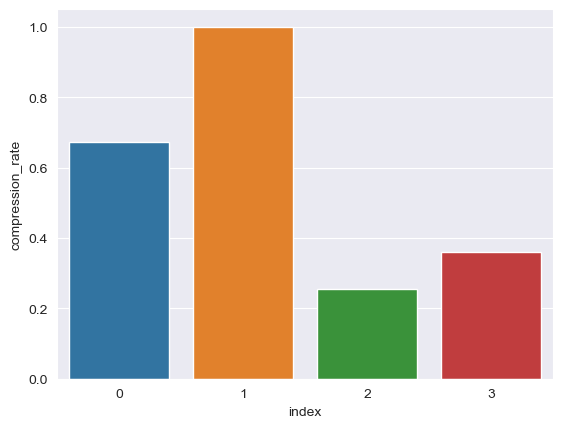

In [106]:
plot_benchmarks(benchmarks, "compression_rate")
for i in benchmarks:
    print(i["compression_rate"])
print(benchmarks)

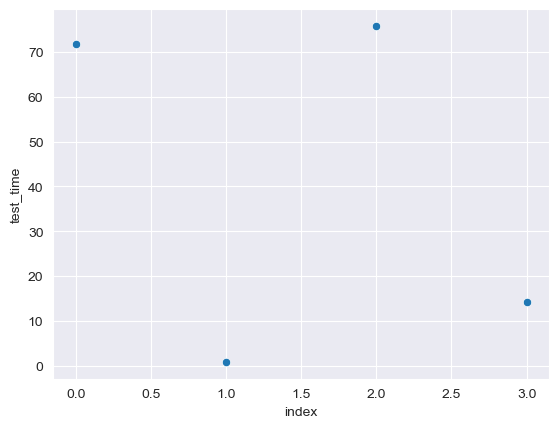

In [93]:
plot_scatter(benchmarks, "test_time")

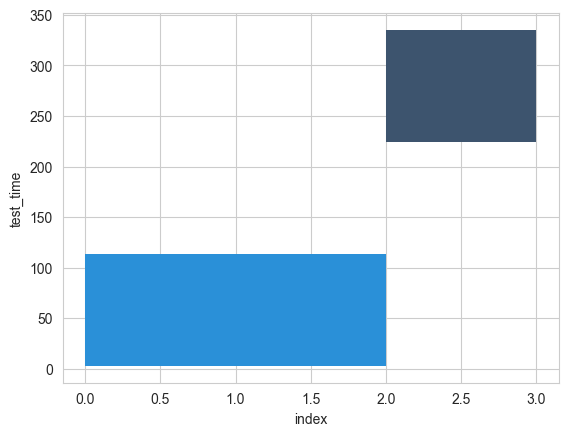

In [44]:
plot_hist(benchmarks, "test_time")